In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE


In [338]:
# Get data
data = pd.read_csv('../resources/data/data_fred_matlab.csv')

# Set date as index of df
data['sasdate'] = pd.to_datetime(data['sasdate'])
data.set_index('sasdate', inplace=True)

# Select only data from 1960-01-01 untill 2019-12-01
data = data.loc[(data.index >= '1960-01-01') & (data.index <= '2019-12-01')]

# Drop last column (unnamed)
data.drop(data.columns[-1], axis=1, inplace=True)

# Drop columns that are not used in original paper
to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "OILPRICEx", "VXOCLSx", "UMCSENTx"]
data.drop(to_drop, axis=1, inplace=True)

print("Data shape: ", data.shape)
data.head()


Data shape:  (720, 123)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.003193,0.004647,0.002784,0.016960,0.026606,0.025916,0.024100,0.029022,0.031235,0.103832,...,-0.002591,-0.001786,-0.001285,-0.004680,0.007797,-0.009705,-0.002451,0.004292,-0.011739,-0.013330
1960-02-01,0.001145,0.000919,0.004327,0.014412,0.003696,-0.008937,-0.005684,-0.003439,-0.011455,-0.013858,...,0.003765,0.001674,0.000767,-0.004555,0.003853,-0.004750,-0.000001,0.008268,0.005388,-0.018942
1960-03-01,0.001910,0.000918,0.014072,-0.028021,-0.001102,-0.009017,-0.003429,-0.001146,0.001154,-0.019963,...,-0.004555,0.001786,-0.001025,-0.000020,0.030131,-0.004684,0.001738,0.003472,0.000951,0.003490
1960-04-01,0.003426,0.003621,0.015382,0.009836,0.025903,-0.007961,0.002287,0.001146,0.006880,-0.001189,...,0.004119,0.004439,0.001531,-0.008949,-0.068074,0.000000,-0.001048,0.008678,0.005452,0.024136
1960-05-01,0.002403,0.002448,-0.020417,-0.031588,-0.015047,-0.001143,0.005691,0.006866,0.005698,0.009454,...,-0.001298,-0.006723,0.000504,0.008949,0.041620,0.000000,0.001035,-0.004827,-0.002067,0.003798


In [252]:
# Inspecting data properties
data['INDPRO'].describe()

count    720.000000
mean       0.002095
std        0.007478
min       -0.044337
25%       -0.001667
50%        0.002385
75%        0.006443
max        0.030432
Name: INDPRO, dtype: float64

In sample PCA to compare to the original paper. Paper uses Jan 1960 to Dec 2019

Explained variances:  [0.14780274 0.07287214 0.06996234 0.05510942 0.04353424 0.03475357
 0.03037988 0.02403926 0.02221615 0.02036149 0.02005939 0.01726613
 0.01645415 0.01611823 0.0154721 ]


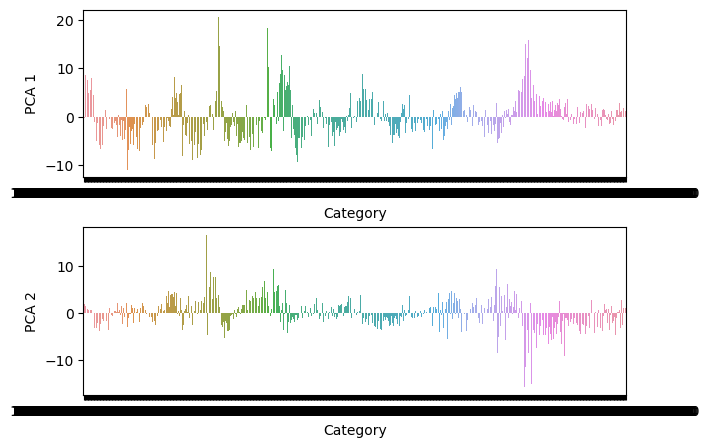

In [266]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create a PCA instance: pca
pca = PCA(n_components=15)

# Normalizer
normalizer = StandardScaler(with_mean=True, with_std=True)

data_pca = normalizer.fit_transform(data)

# Fit the PCA instance to the scaled samples
pca.fit(data_pca)

# Get the explained variances from pca
eigen_values = pca.explained_variance_ratio_

# Eigenvectors are the components
eigen_vectors = pca.components_

print("Explained variances: ", eigen_values)
# Transform the scaled samples: pca_features
pca_features = pca.transform(data_pca)

plots = 2
fig, ax = plt.subplots(plots, 1, figsize=(7, 5))
plt.subplots_adjust(hspace=0.3)

for i in range(plots):
    sns.barplot(x = data.index, y=pca_features[:,i], ax=ax[i])
    ax[i].set_xlabel('Category')
    ax[i].set_ylabel('PCA {}'.format(i+1))


In [347]:
def pc_T(y, nfac):
    bigt, bign = y.shape
    
    # Calculate the inner product of y with itself to get yy
    yy = np.dot(y, y.T)
    
    # Perform eigendecomposition on yy
    eigval, Fhat0 = np.linalg.eig(yy)
    
    # Sort the eigenvalues in descending order and sort the eigenvectors accordingly
    eigval_desc_order = np.argsort(eigval)[::-1]
    eigval_sorted = eigval[eigval_desc_order]
    Fhat0_sorted = Fhat0[:, eigval_desc_order]
    
    # Calculate the estimated factor scores fhat
    fhat = np.dot(Fhat0_sorted[:, :nfac], np.sqrt(bigt))
    
    # Calculate the estimated loading matrix lambda
    lambda_mat = np.dot(y.T, fhat) / bigt
    
    # Calculate the estimated error matrix ehat
    ehat = y - np.dot(fhat, lambda_mat.T)
    
    # Calculate the estimated residual variance for each variable in y
    ve2 = np.sum(ehat**2, axis=1) / bign
    
    # Store the sorted eigenvalues in ss and return all calculated values
    ss = np.real(eigval_sorted)
    
    return ehat, fhat, lambda_mat, ve2, ss


In [389]:
import numpy as np

def winsor(x, p):
    if not np.ndim(x) == 1:
        print("Got x of shape" + str(x.shape) + " dimensions, expected 1")
        raise ValueError('Input argument "x" must be a vector')
    if len(p) != 2:
        raise ValueError('Input argument "p" must be a 2*1 vector')
    if not all(0 <= i <= 100 for i in p):
        raise ValueError('Cut-off percentiles must be in [0,100] range')
    if p[0] > p[1]:
        raise ValueError('Left cut-off percentile exceeds right cut-off percentile')
    p = np.percentile(x, p)

    i1 = x < p[0]
    v1 = np.min(x[~i1])
    i2 = x > p[1]
    v2 = np.max(x[~i2])
    y = x.copy()
    y[i1] = v1
    y[i2] = v2
    if len(np.shape(y)) == 2:
        y = y[:, 0]
    if len(np.shape(x)) == 2:
        x = x[:, 0]
    if np.shape(y) != np.shape(x):
        raise ValueError('Error in dimensions of the input and output vectors')
    if np.any(np.isnan(x)):
        raise ValueError('Input vector contains NaN values')
    if np.any(np.isnan(y)):
        raise ValueError('Output vector contains NaN values')
    if np.any(np.isinf(x)):
        raise ValueError('Input vector contains infinite values')
    if np.any(np.isinf(y)):
        raise ValueError('Output vector contains infinite values')
    if np.any(y == np.inf):
        raise ValueError('Output vector contains infinite values')
    if np.any(y == -np.inf):
        raise ValueError('Output vector contains infinite values')
    
    out = y.reshape(-1, 1)
    # if nargout > 1: ??
    return out

In [417]:
def sPCAest(target, X, nfac, quantile=[0, 100]):
    """
    This function performs sPCA (scaled principal component analysis) on the input data.
    It takes in three input variables, X, target, and nfac, and returns the sPCA factors in f.
    """

    T = len(target)
    if len(X) != T:
        print(f"X is of length {len(X)} and Y is of length {T}")
        raise ValueError('X and Y variables not of equal length')

    # Standardize X to Xs
    normalizer = StandardScaler(with_mean=True, with_std=True)
    Xs = normalizer.fit_transform(X)

    beta = np.empty((1, Xs.shape[1]))
    for j in range(Xs.shape[1]):
        lr = LinearRegression(fit_intercept=True)
        lr.fit(Xs[:, j].reshape(-1, 1), target)
        beta[0, j] = lr.coef_[0]

        #xvar = np.column_stack((np.ones(T), Xs[:, j]))
        #parm = np.linalg.lstsq(xvar, target, rcond=None)[0]
        #beta[0, j] = parm[1]
    
    if quantile[0] != 0 or quantile[1] != 100:
        beta = winsor(np.abs(beta.flatten()), quantile)

    # Scale Xs by the estimated beta
    scaleXs = np.empty((Xs.shape[0], Xs.shape[1]))
    for j in range(Xs.shape[1]):
        scaleXs[:, j] = Xs[:, j] * beta[j]

    # Perform PCA on the scaled Xs
    #pca = PCA(n_components=nfac)
    #pca.fit(scaleXs)
    #f = pca.transform(scaleXs)
    #eigen_values = pca.explained_variance_ratio_
    ehat, f, lambda_mat, ve2, eigen_values = pc_T(scaleXs, nfac)
    return f, eigen_values

In [416]:
h = 1
target = data['INDPRO'].shift(h).values
X, y = data.iloc[h:,:].values, target[h:]

f, eigens = sPCAest(y, X, nfac=1)
print(eigens[:15]/np.sum(eigens))

[0.37660201 0.10435925 0.07144846 0.04604167 0.04116888 0.03333669
 0.02738759 0.02135129 0.01923167 0.01701703 0.01609461 0.01510963
 0.01471301 0.01365757 0.01233292]


In [256]:
def spca_oos(X, target, h_steps=1, test_start='1985-01-01', nfac = 5, scale=True):
    """Out of sample prediction using sPCA"""	

    index_test = data.index.get_loc(test_start)
    T = len(target)

    # Initialize the list of predicted values and actual values
    preds = []
    actuals = []

    # Iterate by an expanding window
    # The first training window is 1960-01-01 to 1985-01-01
    for t in range(index_test, T - h_steps):

        # Split the data into train and test
        X_train, y_train = X[:t], target[:t]
        y_test = target[t]

        # Perform sPCA on the training set to obtain the factors
        factors, _ = sPCAest(y_train, X_train, nfac=nfac)
        
        # Fit the model on the factors obtained on the training set
        lr = LinearRegression(fit_intercept=True)
        lr.fit(factors, y_train)

        # Predict the response variable on the test set for 1 value
        y_pred = lr.predict(factors[-1].reshape(1, -1))

        # Compute the MSE
        preds.append(y_pred)
        actuals.append(y_test)

    return actuals, preds


def spca_is(X, target, nfac=5, scale=True):
    """In sample prediction using sPCA"""

    if scale:
        # Obtain factors from sPCA
        factors, eigen_values = sPCAest(target, X, nfac=nfac)
    else:
        # Normalize X
        Xs = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

        # Obtain factors from PCA
        pca = PCA(n_components=nfac)
        factors = pca.fit_transform(Xs)
        eigen_values = pca.explained_variance_ratio_

    # Fit the model on the factors obtained on the training set
    lr = LinearRegression(fit_intercept=True)
    lr.fit(factors, target)

    # Predict the response variables on the factors from the training set
    y_pred = lr.predict(factors)

    # Return the true values, predicted values, and eigen values
    return target, y_pred, eigen_values


def compute_R2(actuals, preds, adjusted = True, nfac = None):
    """Compute R2 and adjusted R2"""
     
    if adjusted and nfac is None :
        raise ValueError("Need to give number of factors")
    
    SSR_list = []
    SST_list = []
    mean_actuals = np.mean(actuals)

    for i in range(len(actuals)):
        SSR_list.append((actuals[i] - preds[i])**2)
        SST_list.append((actuals[i] - mean_actuals)**2)

    SSR = np.sum(SSR_list)
    SST = np.sum(SST_list)

    print("SSR: ", SSR, "SST: ", SST)
    R2 = 1 - SSR/SST

    if not adjusted:
        return R2
    else:
        n = len(actuals)
        k = nfac
        R2_adj = 1 - (1 - R2) * (n - 1) / (n - k - 1)
        return R2_adj

In [262]:
# Example of using spca functions
h = 1
factors = 1

X = data.drop(columns=["INDPRO"]).values
y = data['INDPRO'].shift(h).values

# Drop the first h rows of X and y
X, y = X[h:], y[h:]

# In sample prediction using sPCA or PCA
actuals, preds, ev = spca_is(X, y, nfac=factors, scale=False)
print("eigen_values: ", ev)
print("R2: ", compute_R2(actuals, preds, nfac=factors, adjusted=True))

eigen_values:  [0.14392541]
SSR:  0.031082760573286166 SST:  0.040175941953635316
R2:  0.22525496129714528


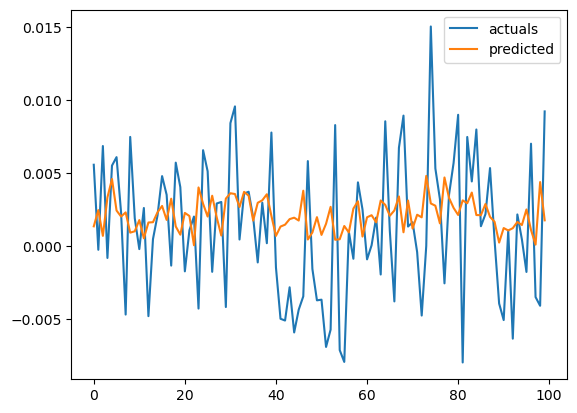

In [248]:
# Plot the actuals and predicted values on a subset of the data
plt.plot(actuals[-100:], label='actuals')
plt.plot(preds[-100:], label='predicted')
plt.legend()
plt.show()

In [250]:
for col in data.columns:
    print(col)

RPI
W875RX1
DPCERA3M086SBEA
CMRMTSPLx
RETAILx
INDPRO
IPFPNSS
IPFINAL
IPCONGD
IPDCONGD
IPNCONGD
IPBUSEQ
IPMAT
IPDMAT
IPNMAT
IPMANSICS
IPB51222S
IPFUELS
CUMFNS
HWI
HWIURATIO
CLF16OV
CE16OV
UNRATE
UEMPMEAN
UEMPLT5
UEMP5TO14
UEMP15OV
UEMP15T26
UEMP27OV
CLAIMSx
PAYEMS
USGOOD
CES1021000001
USCONS
MANEMP
DMANEMP
NDMANEMP
SRVPRD
USTPU
USWTRADE
USTRADE
USFIRE
USGOVT
CES0600000007
AWOTMAN
AWHMAN
HOUST
HOUSTNE
HOUSTMW
HOUSTS
HOUSTW
PERMIT
PERMITNE
PERMITMW
PERMITS
PERMITW
ACOGNO
AMDMNOx
ANDENOx
AMDMUOx
BUSINVx
ISRATIOx
M1SL
M2SL
M2REAL
BOGMBASE
TOTRESNS
NONBORRES
BUSLOANS
REALLN
NONREVSL
CONSPI
S&P 500
S&P: indust
S&P div yield
S&P PE ratio
FEDFUNDS
CP3Mx
TB3MS
TB6MS
GS1
GS5
GS10
AAA
BAA
COMPAPFFx
TB3SMFFM
TB6SMFFM
T1YFFM
T5YFFM
T10YFFM
AAAFFM
BAAFFM
TWEXAFEGSMTHx
EXSZUSx
EXJPUSx
EXUSUKx
EXCAUSx
WPSFD49207
WPSFD49502
WPSID61
WPSID62
OILPRICEx
PPICMM
CPIAUCSL
CPIAPPSL
CPITRNSL
CPIMEDSL
CUSR0000SAC
CUSR0000SAD
CUSR0000SAS
CPIULFSL
CUSR0000SA0L2
CUSR0000SA0L5
PCEPI
DDURRG3M086SBEA
DNDGRG3M086SBEA
DS